# 1.3. Plot results of comparison with Tasker et al. 2020

We finally plot the results for the comparison of all data imputation algorithms using the TLG2020 dataset.

In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor

from knnxkde import KNNxKDE
from utils import normalization, renormalization, compute_epsilon
from utils import convolution_TLG2020_fix_incl
from GAIN.gain import gain

In [3]:
rv_dists = np.load('data/mdists__mask[001111]Ndist2000_2018-08-23_mcsteps3000_loss-0.32_multitrain0_0.npy')
transit_dists = np.load('data/mdists__mask[101111]Ndist2000_2018-08-23_mcsteps3000_loss-0.32_multitrain0_0.npy')

In [4]:
colnames = ['idx', 'pl_name', 'pl_radj', 'pl_bmassj', 'pl_orbper', 'pl_teq', 'pl_pnum', 'st_mass']
all_planets = pd.read_csv('data/NEA_radmasstpersmasspnum.csv', names=colnames, sep=',', skiprows=1)

rs = np.random.RandomState(12345)
dataidx = rs.permutation(all_planets.shape[0])  # it's the very same, I have checked

train_names = all_planets['pl_name'][dataidx[0:400]]
test_names = all_planets['pl_name'][dataidx[400:]]

true_masses = np.array(all_planets.iloc[dataidx[400:]]['pl_bmassj'])
true_radii = np.array(all_planets.iloc[dataidx[400:]]['pl_radj'])

## A. Transit case

Reload imputed masses and plot

In [5]:
with open('results_and_figures/1_comparison_tlg2020/transit_case_imputed_masses.pkl', 'rb') as f:
    imputed_masses = pickle.load(f)

In [6]:
fancy_labels = [
    'mBM TLG2020',
    '$k$NN$\\times$KDE',
    '$k$NN-Imputer',
    'MissForest',
    'GAIN',
    'MICE',
    'Mean',
]

0 rbm_TLG2020
1 knnxkde
2 knnimputer
3 missforest
4 gain
5 mice
6 mean


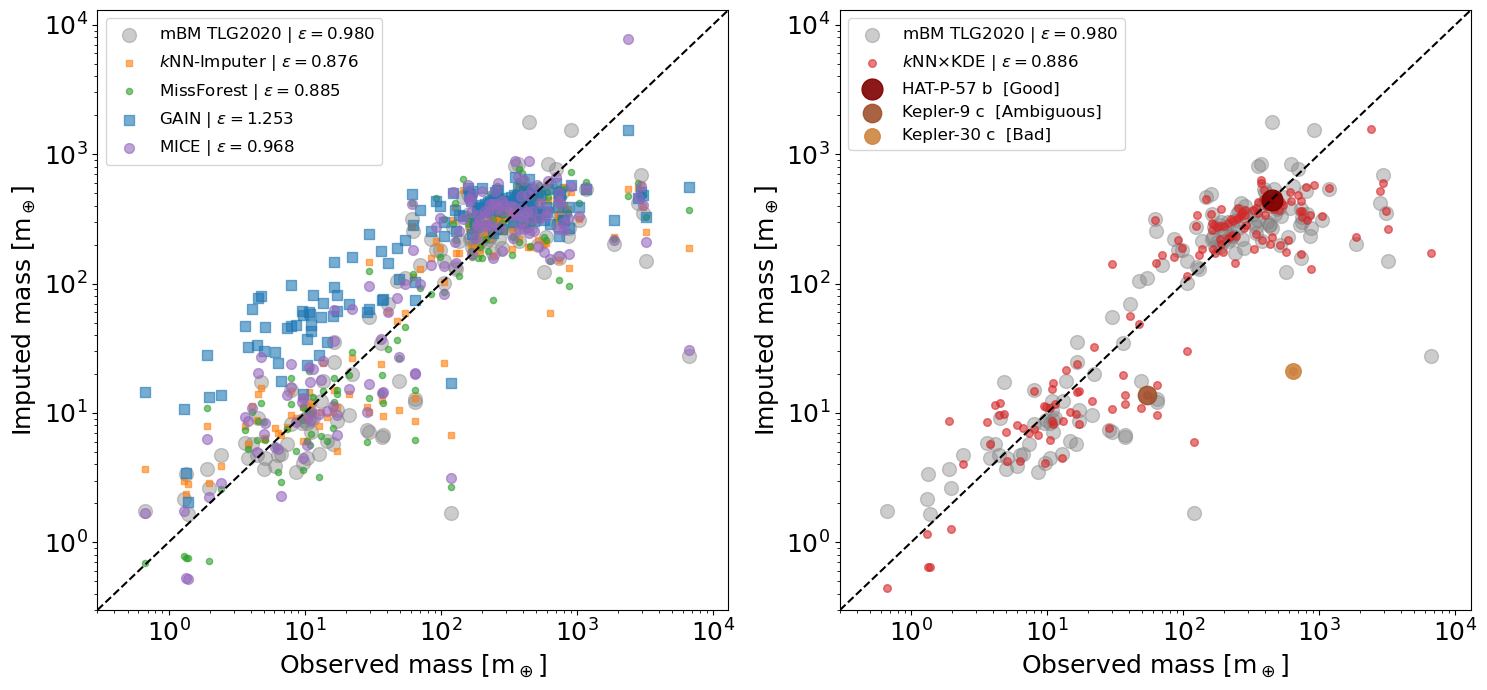

In [7]:
MJ = 317.8  # in Earth masses
MIN_MASS, MAX_MASS = 3e-1, 1.3e4

my_colours = ['C1', 'C2', 'C0', 'C4', 'C5']
my_markers = ['s', 'o', 's', 'o']
my_sizes = [20, 20, 50, 50]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

for i, meth_name in enumerate(imputed_masses.keys()):
    print(i, meth_name)
    if i==6:
        continue
    eps = compute_epsilon(imputed_masses[meth_name], true_masses)
    my_label = fancy_labels[i] + f' | $\\epsilon=${eps:0.3f}'
    if meth_name=='rbm_TLG2020':
        for k in range(2):
            ax[k].scatter(
                true_masses*MJ,
                imputed_masses[meth_name]*MJ,
                c='grey', s=100, alpha=0.4, label=my_label,
            )
    else:
        if meth_name=='knnxkde':
            ax[1].scatter(
                true_masses*MJ,
                imputed_masses[meth_name]*MJ,
                c='C3', s=30, alpha=0.6, label=my_label,
            )
        else:
            ax[0].scatter(
                true_masses*MJ,
                imputed_masses[meth_name]*MJ,
                c=my_colours[i-2], marker=my_markers[i-2], s=my_sizes[i-2], alpha=0.6, label=my_label,
            )

idx1, idx2, idx3 = 104, 139, 65  # HAT-P-57 b (GOOD), Kepler-9 c (AMBIGUOUS), Kepler-30 c (BAD)
ax[1].scatter(true_masses[idx1]*MJ, imputed_masses['knnxkde'][idx1]*MJ, c='maroon', s=225, alpha=0.9, label=test_names.iloc[idx1]+'  [Good]')
ax[1].scatter(true_masses[idx2]*MJ, imputed_masses['knnxkde'][idx2]*MJ, c='sienna', s=175, alpha=0.9, label=test_names.iloc[idx2]+'  [Ambiguous]')
ax[1].scatter(true_masses[idx3]*MJ, imputed_masses['knnxkde'][idx3]*MJ, c='peru', s=125, alpha=0.9, label=test_names.iloc[idx3]+'  [Bad]')

for k in range(2):
    ax[k].set_xscale('log')
    ax[k].set_yscale('log')
    ax[k].plot([MIN_MASS, MAX_MASS], [MIN_MASS, MAX_MASS], 'k--')
    ax[k].set_xlabel('Observed mass [m$_\oplus$]', size=18)
    ax[k].set_ylabel('Imputed mass [m$_\oplus$]', size=18)
    ax[k].tick_params(axis='both', which='major', labelsize=18)
    ax[k].set_xlim(MIN_MASS, MAX_MASS)
    ax[k].set_ylim(MIN_MASS, MAX_MASS)
    ax[k].legend(fontsize=12)

fig.tight_layout()
plt.savefig('results_and_figures/1_comparison_tlg2020/transit_case.pdf')
plt.show()

## B. RV case

Include minimum mass.  
The raw results are not presented.  
They are not bad, but they will never be used in practice since we have a minimum mass measurement.

1. Regenerate $k$NN$\times$KDE samples
2. Perform convolution
3. Plot results

In [11]:
original_data = np.array(all_planets[['pl_radj', 'pl_bmassj', 'pl_orbper', 'pl_teq', 'pl_pnum', 'st_mass']])
log_original_data = np.copy(original_data)
for d in [0, 1, 2, 3, 5]:
    log_original_data[:, d] = np.log(original_data[:, d])  # take the log for all columns except pl_pnum

miss_data = np.copy(log_original_data)
for idx in dataidx[400:]:
    miss_data[idx, 0] = np.nan  # for the RV case: hide the radius...
    miss_data[idx, 1] = np.nan  # and the mass

norm_miss_data, norm_params = normalization(miss_data)
norm_log_original_data, _ = normalization(log_original_data, parameters=norm_params)

In [12]:
MY_TAU = 1.0 / 50.0
MY_NB_NEIGH = 20  # Doesn't matter anymore because we weights (irrelevant neighbours will be thrown away)
knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
np.random.seed(666)  # For reproducibility
knnxkde_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=10000)

In [13]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses
r1 = norm_params['min_val'][0]
r2 = norm_params['max_val'][0]
m1 = norm_params['min_val'][1]
m2 = norm_params['max_val'][1]

rad_distrib_TLG2020 = np.zeros((150, 2000))
rad_distrib_FLO = np.zeros((150, 10000))
mass_distrib_TLG2020 = np.zeros((150, 2000))
mass_distrib_FLO = np.zeros((150, 10000))
for n in range(150):
    rad_distrib_TLG2020[n] = rv_dists[n, :, 0]
    mass_distrib_TLG2020[n] = rv_dists[n, :, 1]
    rad_distrib_FLO[n] = np.exp(knnxkde_samples[(dataidx[400+n], 0)] * (r2 + 1e-6) + r1)
    mass_distrib_FLO[n] = np.exp(knnxkde_samples[(dataidx[400+n], 1)] * (m2 + 1e-6) + m1)

In [14]:
np.random.seed(666)  # For reproducibility
nb_repeat = 100
estimates_TLG2020 = np.zeros((2, 150, nb_repeat))  # radius and mass for each planet
estimates_FLO = np.zeros((2, 150, nb_repeat))  # radius and mass for each planet

for n in range(nb_repeat):
    print(f'{n+1}/{nb_repeat}', end='\r', flush=True)
    cur_i = np.arccos(np.random.uniform()) * 90.0 / (np.pi / 2.0)  # random inclination in degrees
    estimates_TLG2020[0, :, n], estimates_TLG2020[1, :, n] = convolution_TLG2020_fix_incl(
        rad_distrib=rad_distrib_TLG2020,
        mass_distrib=mass_distrib_TLG2020,
        true_masses=true_masses,
        incl=cur_i,
    )
    estimates_FLO[0, :, n], estimates_FLO[1, :, n] = convolution_TLG2020_fix_incl(
        rad_distrib=rad_distrib_FLO,
        mass_distrib=mass_distrib_FLO,
        true_masses=true_masses,
        incl=cur_i,
    )

In [15]:
imp_rad_TLG2020 = np.mean(estimates_TLG2020, axis=-1)[0]
imp_mass_TLG2020 = np.mean(estimates_TLG2020, axis=-1)[1]
imp_rad_FLO = np.mean(estimates_FLO, axis=-1)[0]
imp_mass_FLO = np.mean(estimates_FLO, axis=-1)[1]
eps_rad_TLG2020 = np.sqrt(np.mean((np.log(imp_rad_TLG2020) - np.log(true_radii)) ** 2.0))
eps_mass_TLG2020 = np.sqrt(np.mean((np.log(imp_mass_TLG2020) - np.log(true_masses)) ** 2.0))
eps_rad_FLO = np.sqrt(np.mean((np.log(imp_rad_FLO) - np.log(true_radii)) ** 2.0))
eps_mass_FLO = np.sqrt(np.mean((np.log(imp_mass_FLO) - np.log(true_masses)) ** 2.0))
print(f'Epsilon radius TLG2020 = {eps_rad_TLG2020:.4f}')  # Epsilon radius TLG2020 = 0.3470  //  0.3455
print(f'Epsilon radius FLO = {eps_rad_FLO:.4f}')  # Epsilon radius FLO = 0.3429  //  0.4324
print(f'Epsilon mass TLG2020 = {eps_mass_TLG2020:.4f}')  # Epsilon mass TLG2020 = 0.1071  //  0.1090
print(f'Epsilon mass FLO = {eps_mass_FLO:.4f}')  # Epsilon mass FLO = 0.0694  //  0.3020

Epsilon radius TLG2020 = 0.3472
Epsilon radius FLO = 0.4313
Epsilon mass TLG2020 = 0.1078
Epsilon mass FLO = 0.2912


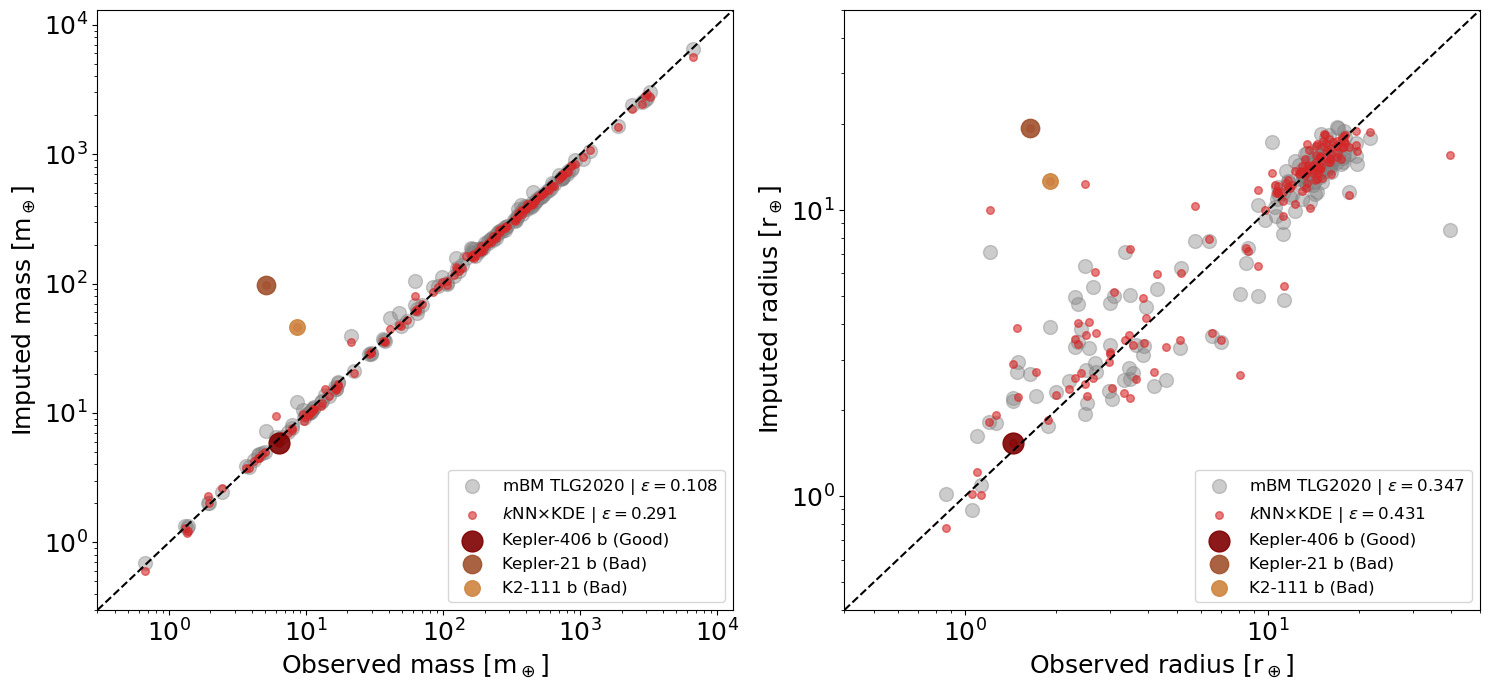

In [16]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses
MIN_RAD, MAX_RAD = 4e-1, 5e1
MIN_MASS, MAX_MASS = 3e-1, 1.3e4

my_label_rad_TLG2020 = f'mBM TLG2020 | $\\epsilon=${eps_rad_TLG2020:0.3f}'
my_label_rad_FLO = f'$k$NN$\\times$KDE | $\\epsilon=${eps_rad_FLO:0.3f}'
my_label_mass_TLG2020 = f'mBM TLG2020 | $\\epsilon=${eps_mass_TLG2020:0.3f}'
my_label_mass_FLO = f'$k$NN$\\times$KDE | $\\epsilon=${eps_mass_FLO:0.3f}'

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[1].scatter(true_radii*RJ, imp_rad_TLG2020*RJ, c='grey', s=100, alpha=0.4, label=my_label_rad_TLG2020)
ax[1].scatter(true_radii*RJ, imp_rad_FLO*RJ, c='C3', s=30, alpha=0.6, label=my_label_rad_FLO)
ax[0].scatter(true_masses*MJ, imp_mass_TLG2020*MJ, c='grey', s=100, alpha=0.4, label=my_label_mass_TLG2020)
ax[0].scatter(true_masses*MJ, imp_mass_FLO*MJ, c='C3', s=30, alpha=0.6, label=my_label_mass_FLO)

idx1, idx2, idx3 = 112, 129, 99  # Kepler-406 b (GOOD), Kepler-21 b (BAD), K2-111 b (BAD)  initial colors: C2; C1; C4
ax[1].scatter(true_radii[idx1]*RJ, imp_rad_FLO[idx1]*RJ, c='maroon', s=225, alpha=0.9, label=test_names.iloc[idx1]+' (Good)')
ax[1].scatter(true_radii[idx2]*RJ, imp_rad_FLO[idx2]*RJ, c='sienna', s=175, alpha=0.9, label=test_names.iloc[idx2]+' (Bad)')
ax[1].scatter(true_radii[idx3]*RJ, imp_rad_FLO[idx3]*RJ, c='peru', s=125, alpha=0.9, label=test_names.iloc[idx3]+' (Bad)')
ax[0].scatter(true_masses[idx1]*MJ, imp_mass_FLO[idx1]*MJ, c='maroon', s=225, alpha=0.9, label=test_names.iloc[idx1]+' (Good)')
ax[0].scatter(true_masses[idx2]*MJ, imp_mass_FLO[idx2]*MJ, c='sienna', s=175, alpha=0.9, label=test_names.iloc[idx2]+' (Bad)')
ax[0].scatter(true_masses[idx3]*MJ, imp_mass_FLO[idx3]*MJ, c='peru', s=125, alpha=0.9, label=test_names.iloc[idx3]+' (Bad)')

for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].tick_params(axis='both', which='major', labelsize=18)
    ax[i].legend(fontsize=12, loc='lower right')
ax[1].set_xlabel('Observed radius [r$_\oplus$]', size=18)
ax[1].set_ylabel('Imputed radius [r$_\oplus$]', size=18)
ax[1].plot([MIN_RAD, MAX_RAD], [MIN_RAD, MAX_RAD], 'k--')
ax[1].set_xlim(MIN_RAD, MAX_RAD)
ax[1].set_ylim(MIN_RAD, MAX_RAD)
ax[0].set_xlabel('Observed mass [m$_\oplus$]', size=18)
ax[0].set_ylabel('Imputed mass [m$_\oplus$]', size=18)
ax[0].plot([MIN_MASS, MAX_MASS], [MIN_MASS, MAX_MASS], 'k--')
ax[0].set_xlim(MIN_MASS, MAX_MASS)
ax[0].set_ylim(MIN_MASS, MAX_MASS)

fig.tight_layout()
plt.savefig('results_and_figures/1_comparison_tlg2020/rv_case_conv_tlg2020_withneighcap666.pdf')
plt.show()

Show the distribution for two specific outliers (Kepler-21 b and K2-111 b)

In [17]:
my_rad_bins = np.geomspace(1e-1, 1e2, num=101)
my_mass_bins = np.geomspace(1e-1, 1e5, num=101)
my_weights_FLO = np.ones(mass_distrib_FLO.shape[-1]) / mass_distrib_FLO.shape[-1]
my_weights_TLG2020 = np.ones(mass_distrib_TLG2020.shape[-1]) / mass_distrib_TLG2020.shape[-1]

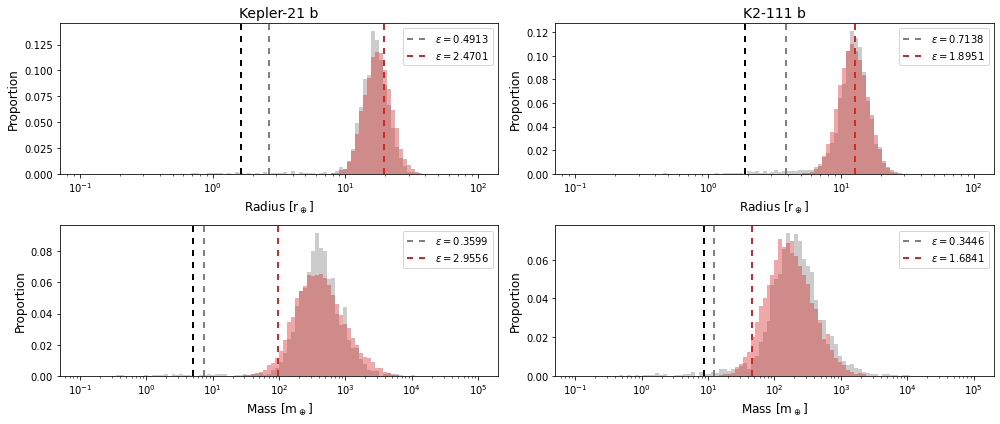

In [110]:
highlight_idx = [129, 99]
fig, ax = plt.subplots(2, 2, figsize=(14, 6))
for n, idx in enumerate(highlight_idx):
    e_r_FLO = np.log(imp_rad_FLO[idx]) - np.log(true_radii[idx])
    e_m_FLO = np.log(imp_mass_FLO[idx]) - np.log(true_masses[idx])
    e_r_TLG2020 = np.log(imp_rad_TLG2020[idx]) - np.log(true_radii[idx])
    e_m_TLG2020 = np.log(imp_mass_TLG2020[idx]) - np.log(true_masses[idx])
    ax[0][n].hist(rad_distrib_TLG2020[idx]*RJ, bins=my_rad_bins, weights=my_weights_TLG2020, color='grey', alpha=0.4)
    ax[0][n].hist(rad_distrib_FLO[idx]*RJ, bins=my_rad_bins, weights=my_weights_FLO, color='C3', alpha=0.4)
    ax[0][n].set_xlabel('Radius [r$_\oplus$]', size=12)
    ax[0][n].axvline(true_radii[idx]*RJ, ls=(0, (3, 3)), c='black', lw=2)
    ax[0][n].axvline(imp_rad_TLG2020[idx]*RJ, ls=(0, (3, 3)), c='grey', lw=2, label=f'$\\varepsilon=${e_r_TLG2020:.4f}')
    ax[0][n].axvline(imp_rad_FLO[idx]*RJ, ls=(0, (3, 3)), c='C3', lw=2, label=f'$\\varepsilon=${e_r_FLO:.4f}')
    ax[1][n].hist(mass_distrib_TLG2020[idx]*MJ, bins=my_mass_bins, weights=my_weights_TLG2020, color='grey', alpha=0.4)
    ax[1][n].hist(mass_distrib_FLO[idx]*MJ, bins=my_mass_bins, weights=my_weights_FLO, color='C3', alpha=0.4)
    ax[1][n].set_xlabel('Mass [m$_\oplus$]', size=12)
    ax[1][n].axvline(true_masses[idx]*MJ, ls=(0, (3, 3)), c='black', lw=2)
    ax[1][n].axvline(imp_mass_TLG2020[idx]*MJ, ls=(0, (3, 3)), c='grey', lw=2, label=f'$\\varepsilon=${e_m_TLG2020:.4f}')
    ax[1][n].axvline(imp_mass_FLO[idx]*MJ, ls=(0, (3, 3)), c='C3', lw=2, label=f'$\\varepsilon=${e_m_FLO:.4f}')
    ax[0][n].set_title(test_names.iloc[idx], size=14)
for n1 in range(2):
    for n2 in range(2):
        ax[n1][n2].set_xscale('log')
        ax[n1][n2].set_ylabel('Proportion', size=12)
        ax[n1][n2].legend()
fig.tight_layout()
plt.savefig('results_and_figures/comparison_tlg2020/rv_case_two_outliers.pdf')
plt.show()